基于此文章修改：[深度学习笔记19_卷积神经网络数据可视化_热力图](http://m.vlambda.com/wz_wEQgnsnvhw.html)

In [1]:
import tensorflow.compat.v1 as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# 载入模型
model = load_model('./model/j.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [3]:
img_path = './pics/cat/3.jpeg'
img = image.load_img(img_path,target_size=(224,224))
# 转化为形状为 (224, 224, 3) 的float32 格式的 Numpy 数组
x = image.img_to_array(img)
# 添加一个维度，将数组转换为(1, 224, 224, 3) 形状的批量
x = np.expand_dims(x,axis = 0)

In [4]:
preds = model.predict(x)
print('Predicted:',preds)

Predicted: [[1. 0.]]


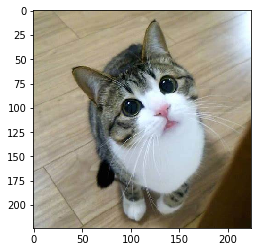

In [5]:
plt.imshow(img)
plt.show()

In [6]:
# 使用 Grad-CAM 算法
#预测向量中的cat元素
cat_output = model.output[:, 1]

#得到指定层的输出特征图，这是model最后一个卷积层
last_conv_layer = model.get_layer('conv2d_4')

# 得到cat在conv2d_4输出特征图的梯度
grads = K.gradients(cat_output,last_conv_layer.output)[0]

#（64，）的向量，每个元素是特征图通道的梯度平均大小
# K.mean()在给定轴上求张量元素之均值 -> pooled_grads的shape变成了(64, )
pooled_grads = K.mean(grads, axis=(0, 1, 2))

#访问pooled_grads：对于给定的样本图像，pooled_grads和max_pooling2d_2层的输出特征图
# K.function(input,output)，这里的input是输入至神经网络的图像，output是梯度平均大小（shape是64,_）和最后一个卷积层的输出（shape是10x10x64）
iterate = K.function([model.input],
                     [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

# 将特征图数组中的每个通道*这个通道对“cat”类别的重要程度。
for i in range(64):
     conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

#得到特征图的逐个通道平均值即类激活热力图    
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [7]:
print(heatmap)

[[ 1.9419935  2.1079903  2.381991   3.3501601  4.7564497  5.6040573
   5.5013676  4.514909   4.174101   7.4194684]
 [ 2.6583343  3.098981   4.367697   5.689177   7.6865287  8.470812
   8.87501    6.9846845  5.166207   6.9836307]
 [ 3.6487985  4.466014   6.4438124  8.334763  11.020939  12.264799
  12.40122    9.903153   7.340491   6.137616 ]
 [ 3.8277512  5.6008596  8.4065    12.193434  14.71369   16.43206
  16.02172   13.130504  10.046267   6.979317 ]
 [ 3.9336421  5.5151978  8.693739  13.538984  16.331764  17.828234
  17.5314    15.11203   12.150461   9.255333 ]
 [ 4.1083784  5.8107796  8.018304  12.702428  15.878545  17.238728
  16.820292  15.1455765 13.199312  10.882049 ]
 [ 4.5169907  6.6250434  8.781002  11.876038  14.399382  15.443603
  15.299728  14.628235  13.184534  12.020959 ]
 [ 4.849846   7.2720027 10.479752  12.648958  14.225651  14.550349
  14.438053  14.199314  13.267286  12.426075 ]
 [ 5.066951   6.7252502  9.979606  12.58285   13.984168  13.9501
  14.255171  14.069586 

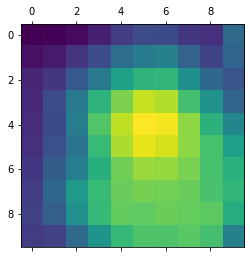

In [8]:
#绘制热力图
import matplotlib.pyplot as plt

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [9]:
# 最后，我们可以用 OpenCV 来生成一张图像，将原始图像叠加在刚刚得到的热力图上
import cv2
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
# 将热力图应用于原始图像
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
# 这里的 0.4 是热力图强度因子
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('heatmap.jpg', superimposed_img)

True

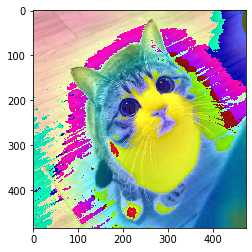

In [10]:
plt.imshow(np.uint8(superimposed_img))
plt.show()